download dataset from https://www.kaggle.com/datasets/adityajn105/flickr8k

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━

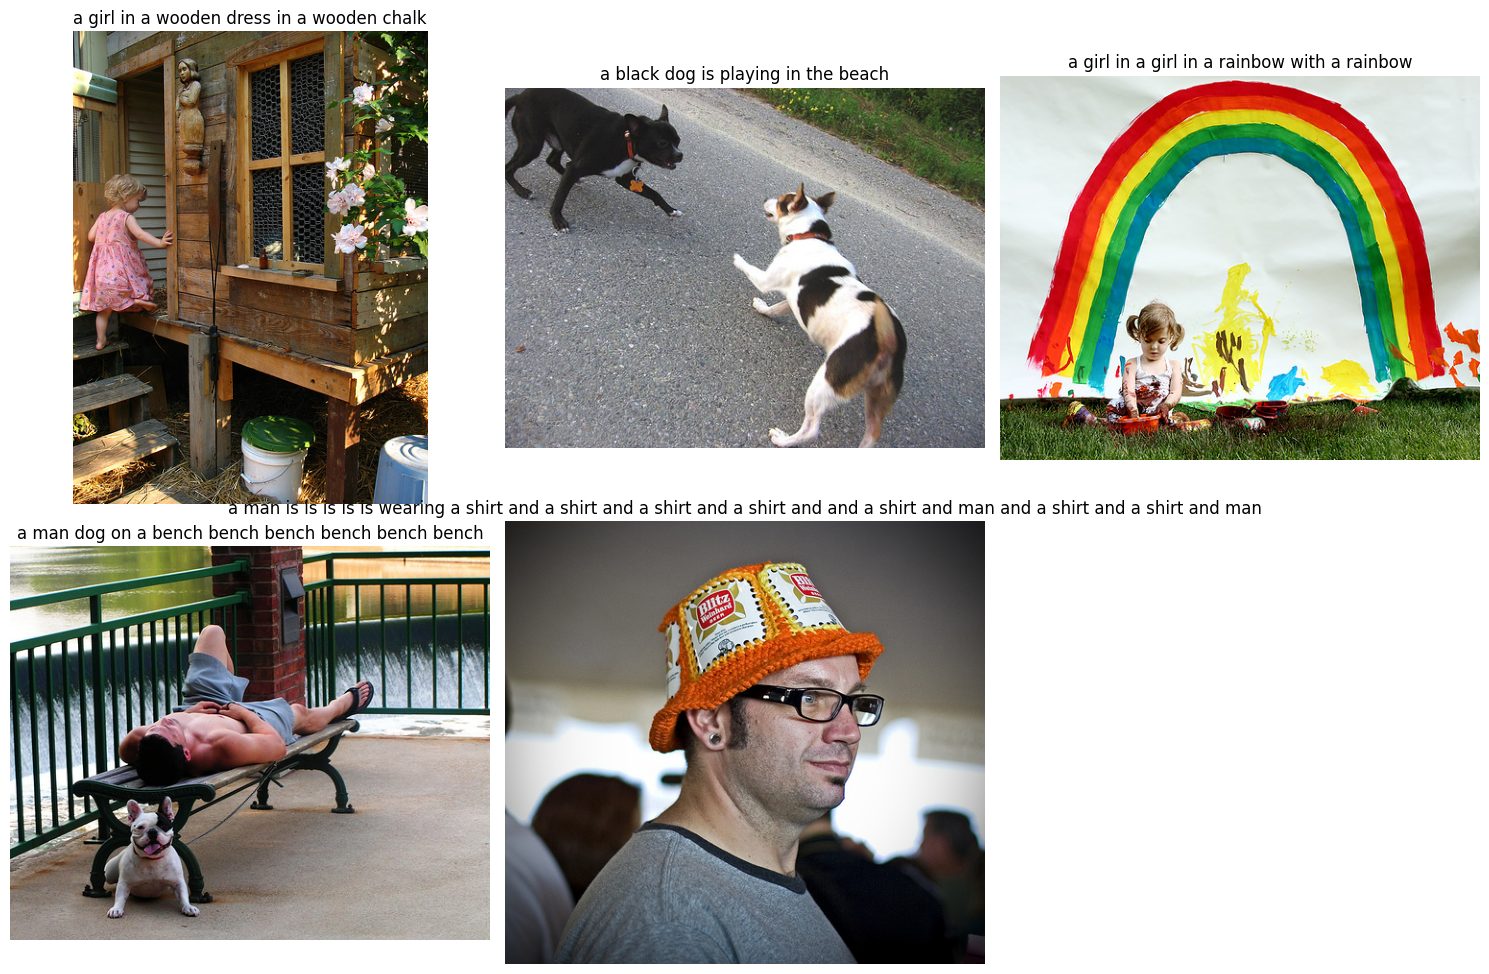

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
from PIL import Image

DATASET_SIZE = 200
images_dir = r'path to image dataset'
captions_file = r'path to caption.txt'

# 1. Load captions from captions.txt
def load_captions(captions_file):
    data = pd.read_csv(captions_file)
    captions = {}
    for _, row in data.iterrows():
        image, caption = row['image'], f"startseq {row['caption']} endseq"
        if image not in captions:
            captions[image] = []
        captions[image].append(caption)
    return captions

# 2. Extract features without a progress bar
def extract_features(images_dir, limit=None):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    features = {}
    img_list = os.listdir(images_dir)[:limit] if limit else os.listdir(images_dir)
    
    for img_name in img_list:
        img_path = os.path.join(images_dir, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = tf.keras.applications.inception_v3.preprocess_input(img)
            tf.get_logger().setLevel('ERROR')
            features[img_name] = model.predict(img).flatten()
            tf.get_logger().setLevel('INFO')
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")
    return features

# 3. Preprocess captions
def preprocess_captions(captions):
    all_captions = [caption for cap_list in captions.values() for caption in cap_list]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    sequences = {img: tokenizer.texts_to_sequences(caps) for img, caps in captions.items()}
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(seq) for seq_list in sequences.values() for seq in seq_list)
    return sequences, tokenizer, vocab_size, max_length

# 4. Create training data
def create_training_data(features, sequences, max_length, vocab_size, limit):
    X1, X2, y = [], [], []
    count = 0
    for img, seq_list in sequences.items():
        for seq in seq_list:
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)
                X1.append(features[img])
                X2.append(in_seq)
                y.append(out_seq)
                count += 1
                if count >= limit:
                    return np.array(X1), np.array(X2), np.array(y)
    return np.array(X1), np.array(X2), np.array(y)

# 5. Define CNN-LSTM model
def define_model(vocab_size, max_length):
    input_image = Input(shape=(2048,))
    image_features = Dropout(0.5)(input_image)
    image_features = Dense(256, activation='relu')(image_features)

    input_sequence = Input(shape=(max_length,))
    sequence_features = Embedding(vocab_size, 256, mask_zero=True)(input_sequence)
    sequence_features = LSTM(256)(sequence_features)

    decoder = add([image_features, sequence_features])
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[input_image, input_sequence], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# 6. Generate caption for an image
def generate_caption(model, tokenizer, photo, max_length):
    caption = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = np.argmax(model.predict([photo, sequence], verbose=0))
        word = tokenizer.index_word.get(prediction)
        if word is None or word == 'endseq':
            break
        caption += ' ' + word
    return caption.replace('startseq', '').replace('endseq', '').strip()

# 7. Calculate BLEU scores
def calculate_bleu_scores(model, tokenizer, features, captions, max_length):
    scores = []
    smoothing_function = SmoothingFunction().method4

    # Ensure only keys present in both features and captions are used
    valid_keys = set(features.keys()).intersection(set(captions.keys()))

    for img_name in valid_keys:
        ground_truths = captions[img_name]
        photo = features[img_name].reshape((1, 2048))
        generated_caption = generate_caption(model, tokenizer, photo, max_length)

        ground_truths_cleaned = [
            gt.replace('startseq', '').replace('endseq', '').strip().split()
            for gt in ground_truths
        ]
        generated_caption_cleaned = generated_caption.split()

        bleu_score = sentence_bleu(
            ground_truths_cleaned,
            generated_caption_cleaned,
            smoothing_function=smoothing_function
        )
        scores.append(bleu_score)

    return scores

# 8. Display images with captions
def display_images_with_captions(images_dir, features, model, tokenizer, max_length):
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(list(features.keys())[:5]):
        img_path = os.path.join(images_dir, img_name)
        img = Image.open(img_path)
        photo = features[img_name].reshape((1, 2048))
        caption = generate_caption(model, tokenizer, photo, max_length)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(caption, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    captions = load_captions(captions_file)
    features = extract_features(images_dir, limit=DATASET_SIZE)
    sequences, tokenizer, vocab_size, max_length = preprocess_captions(captions)
    train_features = {img: features[img] for img in features.keys()}
    train_sequences = {img: sequences[img] for img in features.keys()}

    X1, X2, y = create_training_data(train_features, train_sequences, max_length, vocab_size, limit=5000)

    model = define_model(vocab_size, max_length)
    model.fit([X1, X2], y, epochs=5, batch_size=64, verbose=1)

    # Calculate BLEU scores
    bleu_scores = calculate_bleu_scores(model, tokenizer, features, captions, max_length)
    print(f"Average BLEU score: {np.mean(bleu_scores)}")
    for i, score in enumerate(bleu_scores[:5]):
        print(f"BLEU score for image {i + 1}: {score}")

    # Display images with generated captions
    display_images_with_captions(images_dir, features, model, tokenizer, max_length)